Title: Electric Vehicle Population Analysis


### About the Dataset: Electric Vehicle Population

This dataset contains detailed information about **electric vehicles (EVs) registered in Washington State**, including vehicle specifications, ownership location, and eligibility for clean fuel incentives. Key fields include:

    VIN (1-10):** First 10 characters of the Vehicle Identification Number, unique to each vehicle.
    County, City, State, Postal Code:** Geographic location of the vehicle’s registered owner.
    Model Year & Make:** Vehicle’s model year and manufacturer, decoded from VIN.
    Electric Vehicle Type:** Identifies if the vehicle is **all-electric** or a **plug-in hybrid**.
    CAFV Eligibility:** Indicates if the vehicle qualifies as a **Clean Alternative Fuel Vehicle** under House Bill 2042 (2019).
    Electric Range:** Maximum distance the vehicle can travel on electric power alone.
    Base MSRP:** Lowest Manufacturer’s Suggested Retail Price for the vehicle model.
    Legislative District:** Washington State legislative district of the registered owner.
    DOL Vehicle ID:** Unique identifier assigned by the Department of Licensing.
    Vehicle Location:** Center of the ZIP code for the registered vehicle.
    Electric Utility:** Local electric utility associated with the vehicle.
    2020 Census Tract:** Geographic identifier from the 2020 U.S. Census (state, county, and tract codes).

**Purpose:** This dataset is useful for analyzing **electric vehicle adoption, geographic distribution, market trends, and policy impact** within Washington State.



In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, max, min, round

# Initialize Spark session
spark = SparkSession.builder.appName("ElectricVehiclePollutionAnalysis").getOrCreate()

spark


In [3]:
# Load CSV file into a Spark DataFrame
file_path = "Electric_Vehicle_Polution_Dataset.csv"  # Use your correct file path

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display first few rows
df.show(5)


+----------+---------+-------+-----+-----------+----------+------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|   City|State|Postal Code|Model Year|  Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+-------+-----+-----------+----------+------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|3C3CFFGE4E|   Yakima| Yakima|   WA|      98902|      2014|  FIAT|    500| Battery Electric ...|                             Clean Alternative...|            87|        0|                  14|    

In [4]:
# Print schema of dataset
df.printSchema()

# Count total records
print("Total Records:", df.count())

# Display summary statistics
df.describe().show()


root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)

Total Records: 2038
+-------+----------+------+---------+-----+------------------+------------------+----------+-----+---------------------+-------------------------------------------------+-----------------+-------

In [5]:
# Check for null values in each column
df.select([count(col(c)).alias(c) for c in df.columns]).show()

# Drop rows with missing values (optional)
df_clean = df.na.drop()

print("Rows before cleaning:", df.count())
print("Rows after cleaning:", df_clean.count())


+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|      2038|  2036|2036| 2038|       2036|      2038|2038| 2038|                 2038|                                             2038|          2038|     2038|                2036|          2038|            2036|            2036|             2036|


In [7]:
# Cell A: show column names (so you know the exact names to use)
print("Columns in dataframe:")
for c in df.columns:
    print("-", c)


Columns in dataframe:
- VIN (1-10)
- County
- City
- State
- Postal Code
- Model Year
- Make
- Model
- Electric Vehicle Type
- Clean Alternative Fuel Vehicle (CAFV) Eligibility
- Electric Range
- Base MSRP
- Legislative District
- DOL Vehicle ID
- Vehicle Location
- Electric Utility
- 2020 Census Tract


In [8]:
# Cell B: create df2 with clean column names (replace spaces and special chars with _)
from pyspark.sql.functions import col
import re

def clean_name(c):
    # replace non-alphanumeric characters with underscore
    return re.sub(r'[^0-9a-zA-Z]+', '_', c).strip('_')

old_cols = df.columns
new_cols = [clean_name(c) for c in old_cols]

# rename columns in df to cleaned names
df2 = df
for old, new in zip(old_cols, new_cols):
    if old != new:
        df2 = df2.withColumnRenamed(old, new)

print("Sanitized columns -> use these names from now on:")
for c in df2.columns:
    print("-", c)


Sanitized columns -> use these names from now on:
- VIN_1_10
- County
- City
- State
- Postal_Code
- Model_Year
- Make
- Model
- Electric_Vehicle_Type
- Clean_Alternative_Fuel_Vehicle_CAFV_Eligibility
- Electric_Range
- Base_MSRP
- Legislative_District
- DOL_Vehicle_ID
- Vehicle_Location
- Electric_Utility
- 2020_Census_Tract


In [9]:
# Cell C: parse numeric columns (adjust names if you didn't sanitize)
from pyspark.sql.functions import regexp_replace, trim

# Choose names depending on whether you sanitized:
# If you ran Cell B use df2 and sanitized names like Base_MSRP, Electric_Range, Model_Year
# If not, use df (original) and exact column names printed earlier
use_df = df2 if 'df2' in globals() else df

# Common numeric columns to coerce (adjust these names if necessary)
candidates = {
    "Base_MSRP": ["Base_MSRP", "Base MSRP"], 
    "Electric_Range": ["Electric_Range", "Electric Range"],
    "Model_Year": ["Model_Year", "Model Year"]
}

# find actual available names from candidates
available = {}
for key, options in candidates.items():
    for opt in options:
        if opt in use_df.columns:
            available[key] = opt
            break

print("Columns found for numeric conversion:", available)

# convert strings like "$45,000" to numeric: remove $ and commas, cast to double
df_num = use_df
from pyspark.sql.types import DoubleType, IntegerType
for key, colname in available.items():
    # remove $ and commas, trim, cast
    df_num = df_num.withColumn(colname, regexp_replace(trim(col(colname)), '[$,]', '').cast(DoubleType() if key!="Model_Year" else IntegerType()))

# Quick check
display(df_num.select(list(available.values())[:10]).limit(10).toPandas())


Columns found for numeric conversion: {'Base_MSRP': 'Base_MSRP', 'Electric_Range': 'Electric_Range', 'Model_Year': 'Model_Year'}


,Base_MSRP,Electric_Range,Model_Year
0,0.0,87.0,2014
1,0.0,200.0,2017
2,0.0,20.0,2023
3,0.0,0.0,2023
4,0.0,322.0,2020
5,0.0,39.0,2024
6,0.0,33.0,2018
7,0.0,238.0,2017
8,0.0,215.0,2018
9,0.0,114.0,2018


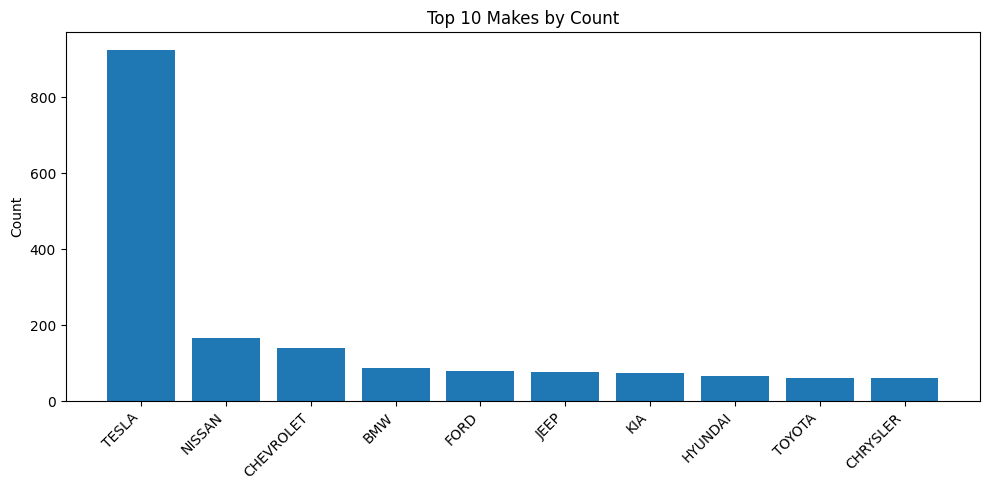

In [10]:
# Cell E: convert an analysis result to pandas for plotting
import matplotlib.pyplot as plt

use_df = df_num  # same as above

# Example: bar chart of Top 10 Makes
if "Make" in use_df.columns:
    top_makes = use_df.groupBy("Make").count().orderBy(col("count").desc()).limit(10).toPandas()
    plt.figure(figsize=(10,5))
    plt.bar(top_makes['Make'].astype(str), top_makes['count'])
    plt.title("Top 10 Makes by Count")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No 'Make' column available to plot.")


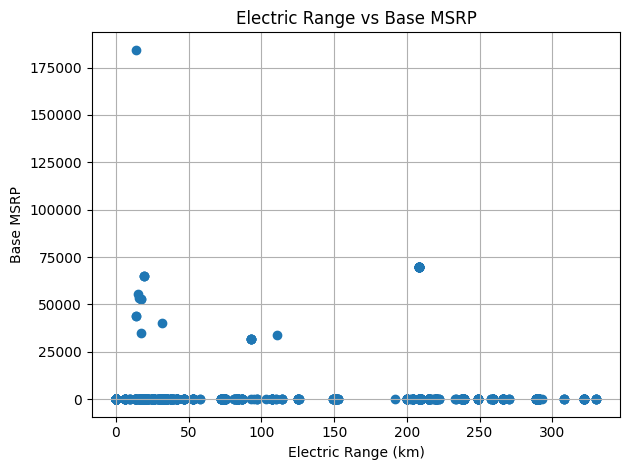

In [17]:
# Cell 6: Data Visualization (matplotlib only). Works with sanitized columns you provided.
# Requires that df_num, df2, or df exist in the notebook (prefer df_num after numeric conversion).

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# choose the Spark DataFrame variable that exists (preference: df_num -> df2 -> df)
spark_df = None
if 'df_num' in globals():
    spark_df = df_num
elif 'df2' in globals():
    spark_df = df2
elif 'df' in globals():
    spark_df = df
else:
    raise NameError("No Spark DataFrame variable found. Run earlier cells (A-D) first.")

# Helper to convert Spark DF to pandas safely (limit rows to avoid OOM)
def to_pandas_safe(sdf, n=20000):
    try:
        # If Spark DataFrame, limit then toPandas
        if hasattr(sdf, "limit"):
            pd_df = sdf.limit(n).toPandas()
        else:
            pd_df = pd.DataFrame(sdf)  # already pandas-like
        return pd_df
    except Exception as e:
        raise RuntimeError("Failed to convert to pandas: " + str(e))

# Convert a reasonably-sized subset for plotting
pdf = to_pandas_safe(spark_df)

# Ensure numeric columns are numeric in pandas (they should be if converted earlier)
for col in ["Base_MSRP", "Electric_Range", "Model_Year"]:
    if col in pdf.columns:
        pdf[col] = pd.to_numeric(pdf[col], errors='coerce')

# 1) Scatter: Electric Range vs Base MSRP (if both present)
if "Electric_Range" in pdf.columns and "Base_MSRP" in pdf.columns:
    data = pdf[["Electric_Range", "Base_MSRP"]].dropna()
    if not data.empty:
        plt.figure()
        plt.scatter(data["Electric_Range"], data["Base_MSRP"])
        plt.xlabel("Electric Range (km)")
        plt.ylabel("Base MSRP")
        plt.title("Electric Range vs Base MSRP")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Scatter: no non-null rows for Electric_Range/Base_MSRP.")



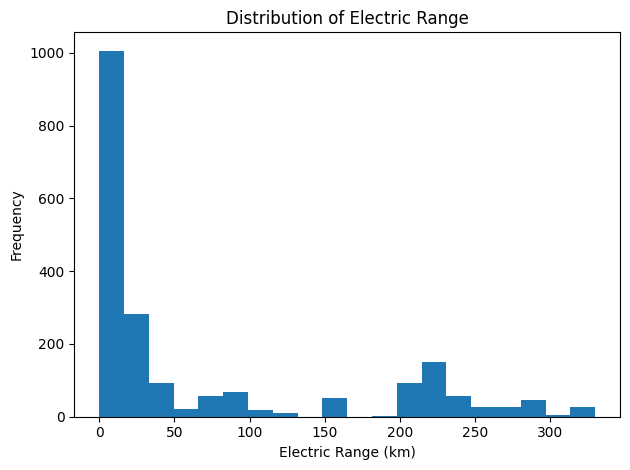

In [13]:

# 2) Histogram: Electric Range distribution
if "Electric_Range" in pdf.columns:
    data = pdf["Electric_Range"].dropna()
    if not data.empty:
        plt.figure()
        plt.hist(data, bins=20)
        plt.xlabel("Electric Range (km)")
        plt.ylabel("Frequency")
        plt.title("Distribution of Electric Range")
        plt.tight_layout()
        plt.show()
    else:
        print("Histogram: Electric_Range has no non-null values.")


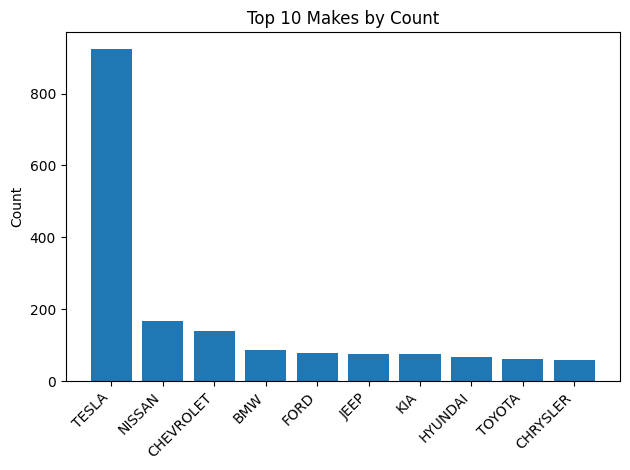

In [15]:

# 3) Bar: Top 10 Makes by count
if "Make" in pdf.columns:
    top_makes = pdf["Make"].value_counts().head(10)
    if not top_makes.empty:
        plt.figure()
        plt.bar(top_makes.index.astype(str), top_makes.values)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Count")
        plt.title("Top 10 Makes by Count")
        plt.tight_layout()
        plt.show()
    else:
        print("Bar: no Make values to plot.")

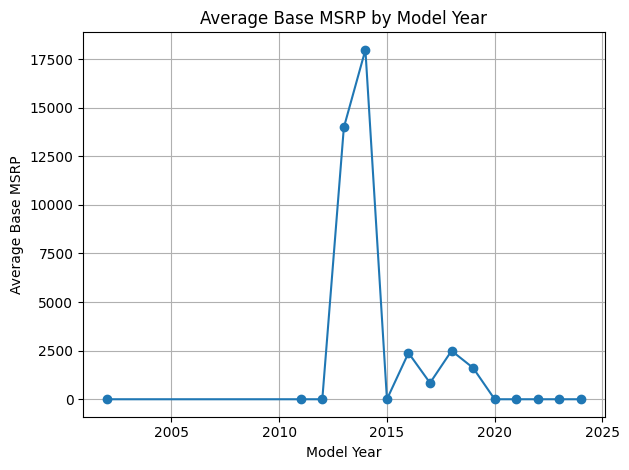

In [16]:

# 4) Line: Trend of average Base MSRP by Model Year (if Model_Year present)
if "Model_Year" in pdf.columns and "Base_MSRP" in pdf.columns:
    grp = pdf.dropna(subset=["Model_Year", "Base_MSRP"]).groupby("Model_Year")["Base_MSRP"].mean().reset_index().sort_values("Model_Year")
    if not grp.empty:
        plt.figure()
        plt.plot(grp["Model_Year"], grp["Base_MSRP"], marker='o')
        plt.xlabel("Model Year")
        plt.ylabel("Average Base MSRP")
        plt.title("Average Base MSRP by Model Year")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Line: insufficient data for Model_Year vs Base_MSRP.")


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\70470843.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups.tolist(), labels=groups.index.astype(str))


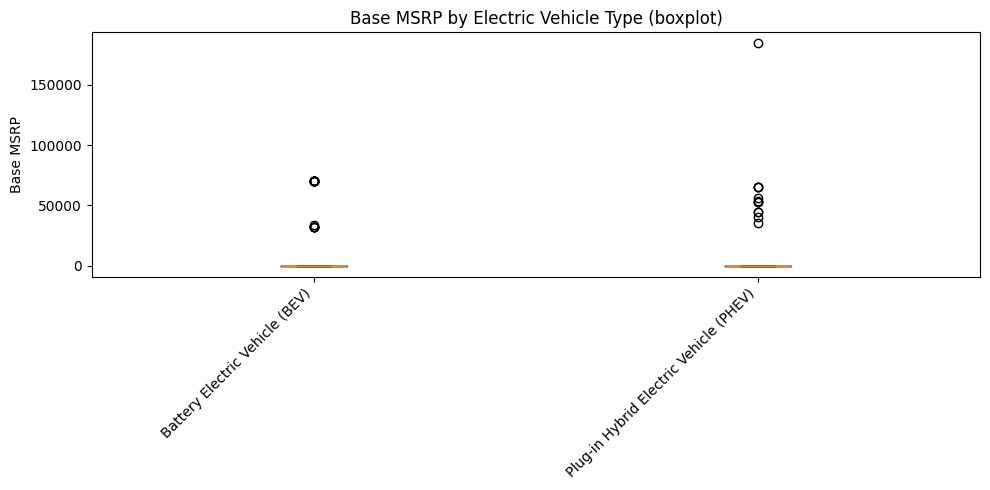

Visualization cell complete.


In [14]:

# 5) Optional: Boxplot of Base MSRP by Electric Vehicle Type
if "Electric_Vehicle_Type" in pdf.columns and "Base_MSRP" in pdf.columns:
    box_df = pdf[["Electric_Vehicle_Type", "Base_MSRP"]].dropna()
    if not box_df.empty:
        groups = box_df.groupby("Electric_Vehicle_Type")["Base_MSRP"].apply(list)
        plt.figure(figsize=(10,5))
        plt.boxplot(groups.tolist(), labels=groups.index.astype(str))
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Base MSRP")
        plt.title("Base MSRP by Electric Vehicle Type (boxplot)")
        plt.tight_layout()
        plt.show()
    else:
        print("Boxplot: insufficient data for Electric_Vehicle_Type vs Base_MSRP.")

print("Visualization cell complete.")


In [18]:
# Cell 1 — imports and pick the Spark DataFrame variable that exists
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# choose the Spark DataFrame variable that exists (preference order)
if 'df_num' in globals():
    spark_df = df_num
elif 'df2' in globals():
    spark_df = df2
elif 'df' in globals():
    spark_df = df
else:
    raise NameError("No Spark DataFrame found. Run earlier cells (A-D) first to create df / df2 / df_num.")

print("Using dataframe variable:", [v for v in ('df_num','df2','df') if v in globals()][0])


Using dataframe variable: df_num


In [19]:
# Cell 2 — convert to pandas safely (limit rows) and coerce numeric columns
def to_pandas_safe(sdf, n=30000):
    """Limit to n rows then toPandas (if sdf is spark DF) or copy if already pandas."""
    if hasattr(sdf, "limit"):
        return sdf.limit(n).toPandas()
    else:
        return pd.DataFrame(sdf)

pdf = to_pandas_safe(spark_df, n=30000)  # adjust n if your machine can handle more

# Normalize column names (they're already sanitized in your case)
pdf.columns = [c for c in pdf.columns]

# Coerce commonly useful numeric columns to numeric dtype (no-op if not present)
for col in ["Base_MSRP", "Electric_Range", "Model_Year"]:
    if col in pdf.columns:
        pdf[col] = pd.to_numeric(pdf[col], errors='coerce')

# Identify numeric columns automatically
numeric_cols = pdf.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns detected:", numeric_cols)

# Basic info
print("Rows (pandas sample):", pdf.shape[0])
print("Columns:", pdf.shape[1])


Numeric columns detected: ['Postal_Code', 'Model_Year', 'Electric_Range', 'Base_MSRP', 'Legislative_District', 'DOL_Vehicle_ID', '2020_Census_Tract']
Rows (pandas sample): 2038
Columns: 17


Numeric targets: ['Base_MSRP', 'Electric_Range']
Categorical columns considered: ['Make', 'Electric_Vehicle_Type', 'City', 'County', 'State']

Top groups for Base_MSRP by Make (top 10 by count):


,count,mean,median,std
Make,,,,
TESLA,924,1512.987013,0.0,10177.463481
NISSAN,167,0.000000,0.0,0.000000
CHEVROLET,139,0.000000,0.0,0.000000
BMW,87,2267.816092,0.0,10452.678462
FORD,79,0.000000,0.0,0.000000
JEEP,76,0.000000,0.0,0.000000
KIA,74,2617.567568,0.0,8874.769657
HYUNDAI,66,0.000000,0.0,0.000000
TOYOTA,61,0.000000,0.0,0.000000


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


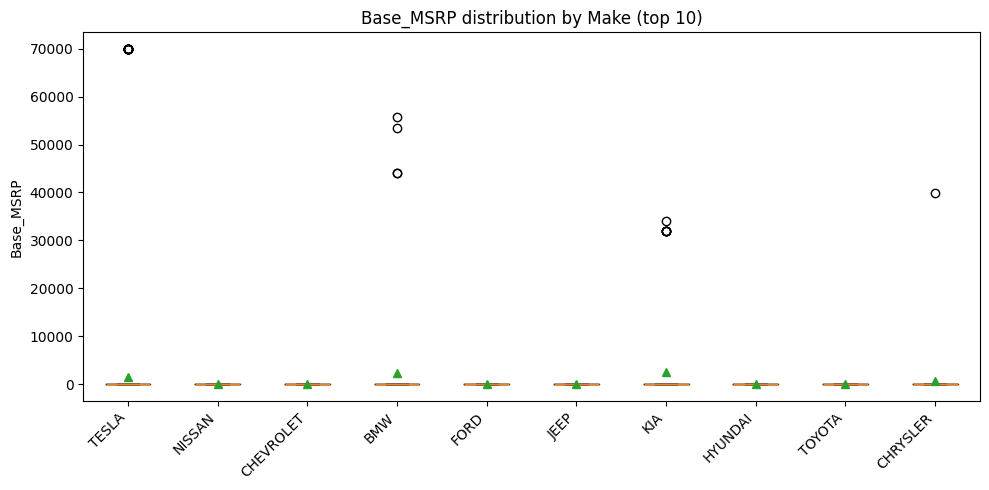


Top groups for Base_MSRP by Electric_Vehicle_Type (top 10 by count):


,count,mean,median,std
Electric_Vehicle_Type,,,,
Battery Electric Vehicle (BEV),1585,1004.227129,0.0,8039.453954
Plug-in Hybrid Electric Vehicle (PHEV),453,1671.832230,0.0,11867.396227


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


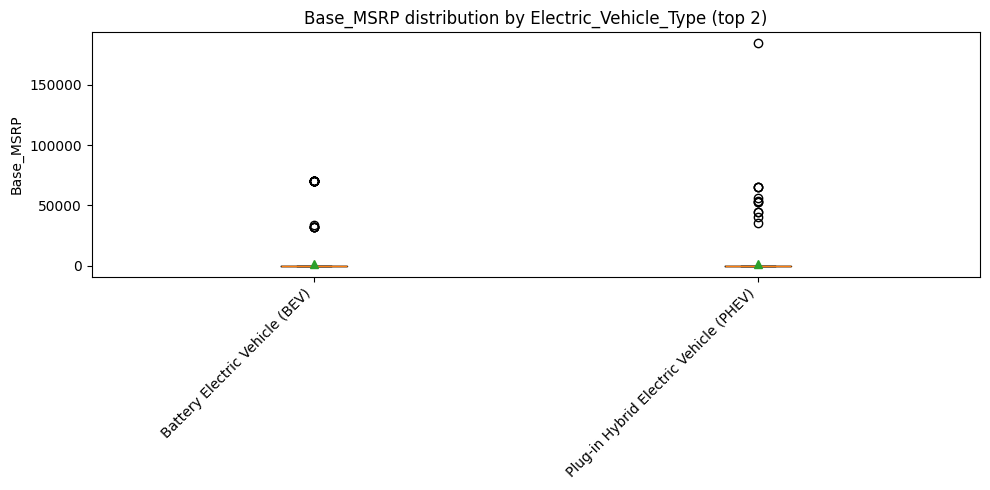


Top groups for Base_MSRP by City (top 10 by count):


,count,mean,median,std
City,,,,
Seattle,359,538.161560,0.0,5913.625774
Bellevue,208,1008.173077,0.0,8354.065835
Kirkland,206,1760.169903,0.0,10352.048512
Tukwila,152,0.000000,0.0,0.000000
Vancouver,128,0.000000,0.0,0.000000
Redmond,98,1376.020408,0.0,9588.952056
Kent,58,1756.034483,0.0,10024.496652
Bothell,49,714.183673,0.0,4999.285714
Renton,48,1160.416667,0.0,8039.602498


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


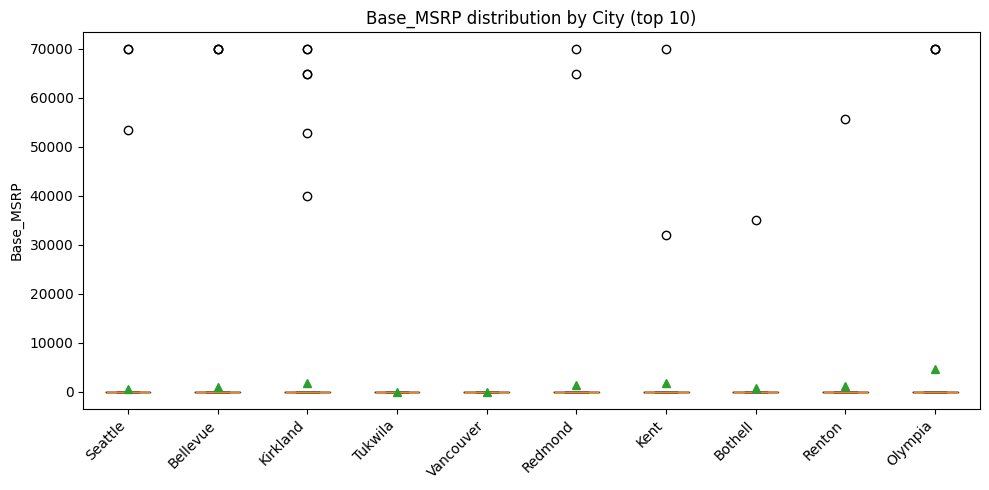


Top groups for Base_MSRP by County (top 10 by count):


,count,mean,median,std
County,,,,
King,1453,950.199587,0.0,7681.265400
Clark,164,1124.390244,0.0,14399.220846
Snohomish,124,1177.016129,0.0,7901.752917
Kitsap,115,1901.304348,0.0,9519.650639
Thurston,77,3631.168831,0.0,15614.081530
Yakima,30,2330.000000,0.0,12761.935590
Jefferson,18,0.000000,0.0,0.000000
Cowlitz,13,0.000000,0.0,0.000000
Skagit,10,0.000000,0.0,0.000000


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


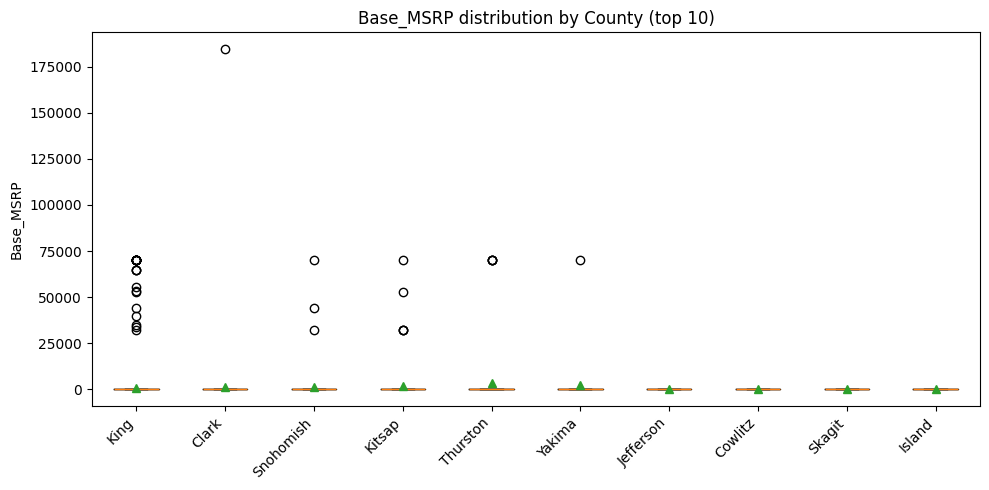


Top groups for Base_MSRP by State (top 10 by count):


,count,mean,median,std
State,,,,
WA,2036,1153.752456,0.0,9036.921588
AE,1,0.000000,0.0,NaN
BC,1,0.000000,0.0,NaN


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


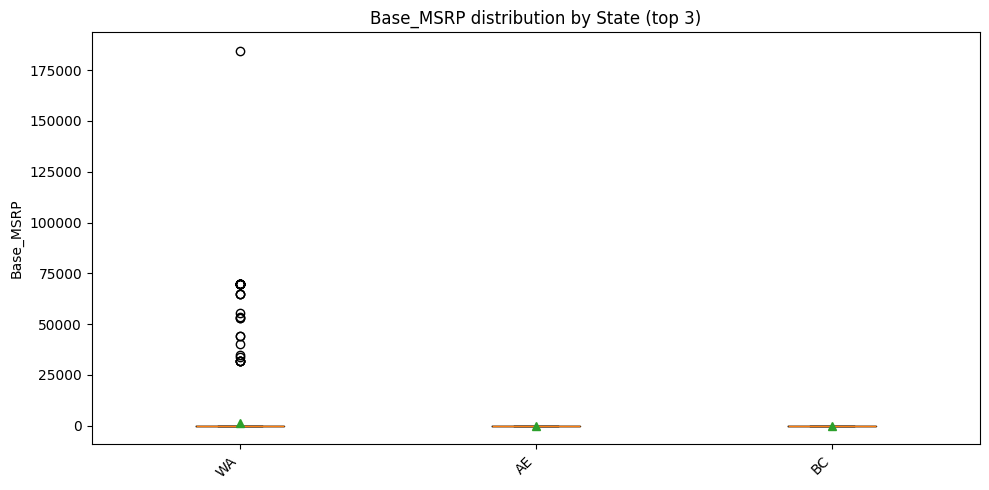


Top groups for Electric_Range by Make (top 10 by count):


,count,mean,median,std
Make,,,,
TESLA,924,90.649351,0.0,118.246114
NISSAN,167,90.898204,84.0,53.490528
CHEVROLET,139,88.482014,38.0,105.064394
BMW,87,42.229885,30.0,42.801516
FORD,79,11.860759,19.0,13.533183
JEEP,76,22.000000,21.0,1.697056
KIA,74,53.797297,26.0,82.669996
HYUNDAI,66,15.924242,0.0,54.281690
TOYOTA,61,26.147541,25.0,18.820942


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


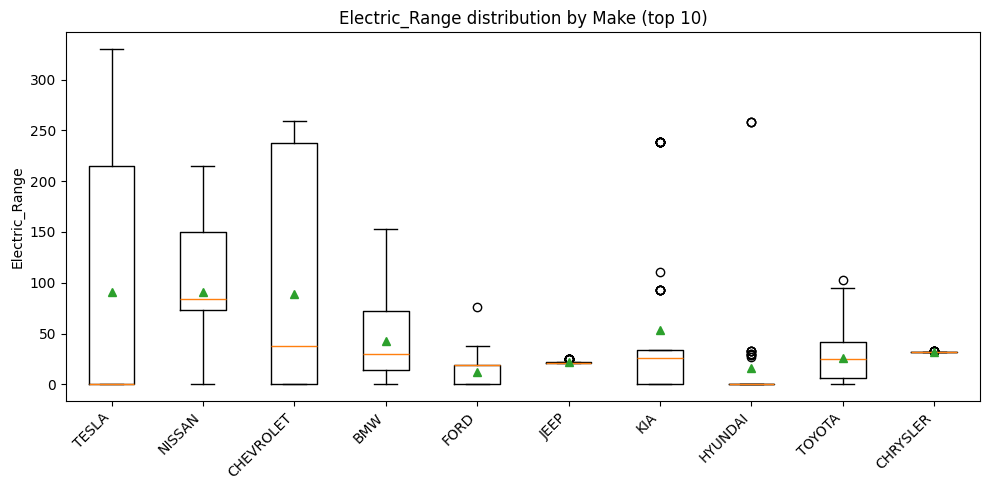


Top groups for Electric_Range by Electric_Vehicle_Type (top 10 by count):


,count,mean,median,std
Electric_Vehicle_Type,,,,
Battery Electric Vehicle (BEV),1585,77.307886,0.0,105.717426
Plug-in Hybrid Electric Vehicle (PHEV),453,29.260486,26.0,15.228297


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


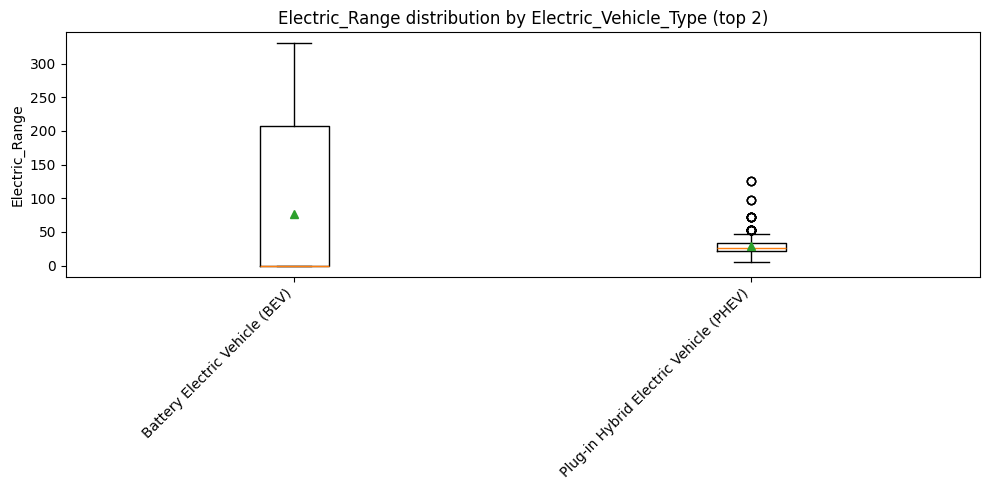


Top groups for Electric_Range by City (top 10 by count):


,count,mean,median,std
City,,,,
Seattle,359,64.771588,16.0,93.163808
Bellevue,208,72.769231,0.0,100.632899
Kirkland,206,59.053398,0.0,92.916811
Tukwila,152,17.848684,21.0,23.143594
Vancouver,128,64.328125,18.0,95.656629
Redmond,98,75.591837,0.0,105.368752
Kent,58,69.775862,0.0,110.306915
Bothell,49,44.591837,0.0,87.696902
Renton,48,47.333333,0.0,85.857213


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


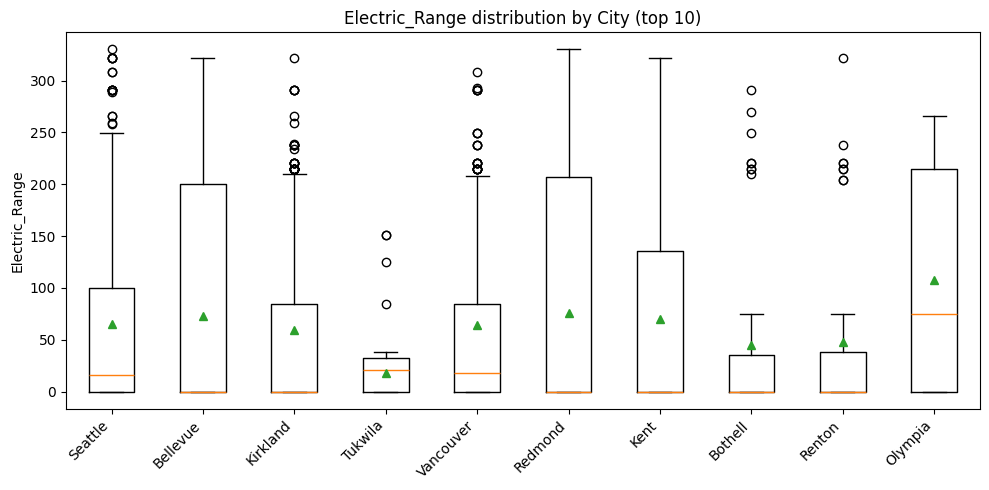


Top groups for Electric_Range by County (top 10 by count):


,count,mean,median,std
County,,,,
King,1453,59.790778,0.0,92.233565
Clark,164,62.664634,17.0,94.038256
Snohomish,124,82.677419,21.0,105.569578
Kitsap,115,89.660870,33.0,106.809462
Thurston,77,94.025974,53.0,100.339158
Yakima,30,103.833333,53.0,93.294892
Jefferson,18,81.166667,57.5,94.113980
Cowlitz,13,111.076923,25.0,125.442857
Skagit,10,119.800000,79.5,88.814163


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


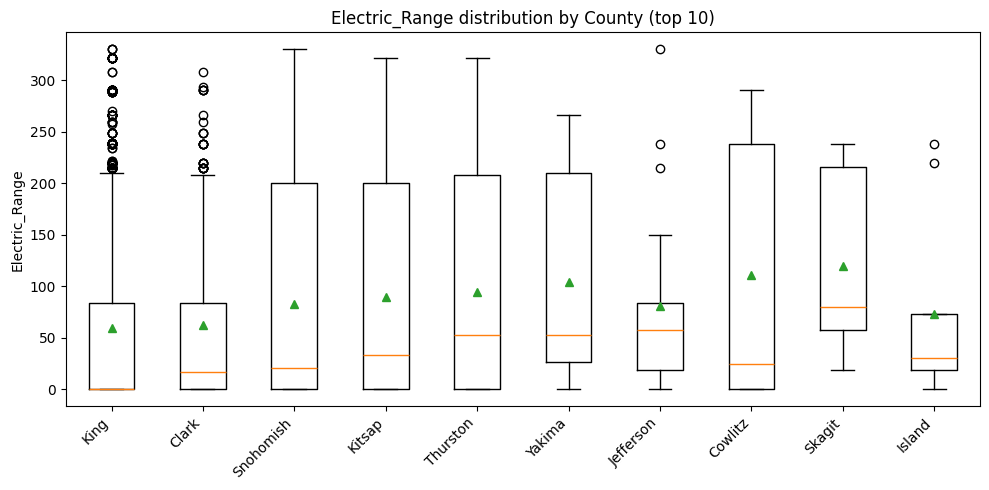


Top groups for Electric_Range by State (top 10 by count):


,count,mean,median,std
State,,,,
WA,2036,66.472986,18.0,95.526745
AE,1,249.000000,249.0,NaN
BC,1,200.000000,200.0,NaN


C:\Users\Harini\AppData\Local\Temp\ipykernel_4528\3507984243.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)


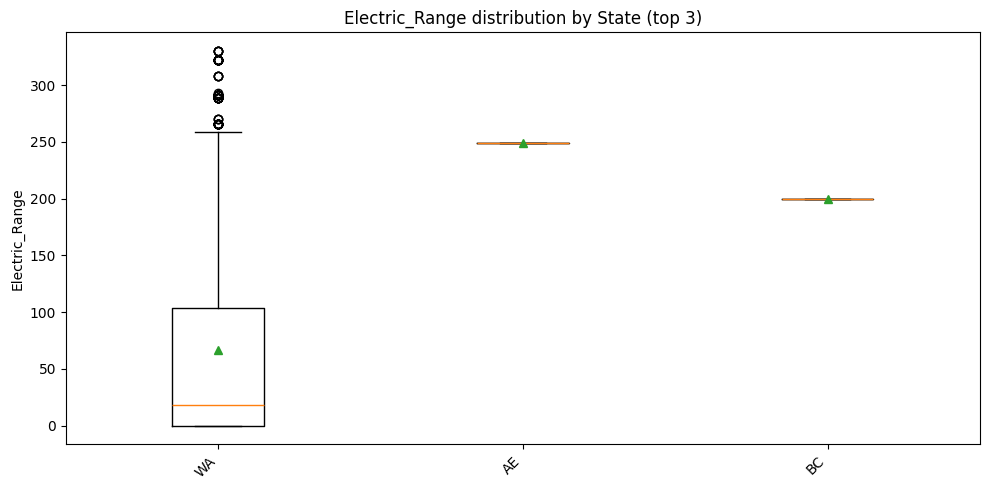

In [23]:
# Cell 5 — examine relationships between categorical columns and numeric targets
# We'll consider two key numeric targets (if present): Base_MSRP and Electric_Range
numeric_targets = [c for c in ["Base_MSRP", "Electric_Range"] if c in pdf.columns]
categorical_cols = [c for c in ["Make", "Electric_Vehicle_Type", "City", "County", "State"] if c in pdf.columns]

print("Numeric targets:", numeric_targets)
print("Categorical columns considered:", categorical_cols)

for num in numeric_targets:
    for cat in categorical_cols:
        # compute aggregated stats
        grp = pdf.groupby(cat)[num].agg(['count','mean','median','std']).sort_values('count', ascending=False)
        top = grp.head(10)
        print(f"\nTop groups for {num} by {cat} (top 10 by count):")
        display(top)

        # Boxplot for top N categories by count
        top_categories = top.index.tolist()
        box_df = pdf[pdf[cat].isin(top_categories)][[cat, num]].dropna()
        if not box_df.empty:
            data_to_plot = [box_df[box_df[cat]==catname][num].values for catname in top_categories]
            plt.figure(figsize=(10,5))
            plt.boxplot(data_to_plot, labels=[str(x) for x in top_categories], showmeans=True)
            plt.xticks(rotation=45, ha='right')
            plt.ylabel(num)
            plt.title(f"{num} distribution by {cat} (top {len(top_categories)})")
            plt.tight_layout()
            plt.show()
        else:
            print(f"No data to plot for {num} by {cat}.")


In [26]:
# Cell 1 — choose available Spark DF and convert to pandas safely
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from IPython.display import display

plt.rcParams["figure.figsize"] = (8,5)

# pick the Spark DF variable that exists (preference order)
for var in ('df_num','df2','df_clean','df'):
    if var in globals():
        spark_df = globals()[var]
        print("Using dataframe variable:", var)
        break
else:
    raise NameError("No dataframe found. Run earlier cells to create df / df2 / df_num / df_clean.")

def to_pandas_safe(sdf, n=20000):
    if hasattr(sdf, "limit"):
        return sdf.limit(n).toPandas()
    else:
        return pd.DataFrame(sdf).head(n)

pdf = to_pandas_safe(spark_df, n=20000)
print("Pandas sample shape:", pdf.shape)
display(pdf.head())


Using dataframe variable: df_num
Pandas sample shape: (2038, 17)


,VIN_1_10,County,City,State,Postal_Code,Model_Year,Make,Model,Electric_Vehicle_Type,Clean_Alternative_Fuel_Vehicle_CAFV_Eligibility,Electric_Range,Base_MSRP,Legislative_District,DOL_Vehicle_ID,Vehicle_Location,Electric_Utility,2020_Census_Tract
0,3C3CFFGE4E,Yakima,Yakima,WA,98902.0,2014,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,87.0,0.0,14.0,1593721,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10
1,5YJXCBE40H,Thurston,Olympia,WA,98513.0,2017,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,200.0,0.0,2.0,257167501,POINT (-122.817545 46.98876),PUGET SOUND ENERGY INC,5.306701e+10
2,3MW39FS03P,King,Renton,WA,98058.0,2023,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,20.0,0.0,11.0,224071816,POINT (-122.1298876 47.4451257),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
3,7PDSGABA8P,Snohomish,Bothell,WA,98012.0,2023,RIVIAN,R1S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,21.0,260084653,POINT (-122.1873 47.820245),PUGET SOUND ENERGY INC,5.306105e+10
4,5YJ3E1EB8L,King,Kent,WA,98031.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322.0,0.0,33.0,253771913,POINT (-122.2012521 47.3931814),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10


In [27]:
# Cell 2 — coerce numeric-like columns and show summary
for col in ["Base_MSRP", "Electric_Range", "Model_Year"]:
    if col in pdf.columns:
        # remove $ and commas then convert
        pdf[col] = pd.to_numeric(pdf[col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')

print("Columns:")
print(list(pdf.columns))
print("\nNon-null counts (top):")
display(pdf.count().sort_values(ascending=False).head(20))

numeric_cols = pdf.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns detected:", numeric_cols)

print("\nDescriptive stats for numeric columns:")
if numeric_cols:
    display(pdf[numeric_cols].describe().T)
else:
    print("No numeric columns detected.")


Columns:
['VIN_1_10', 'County', 'City', 'State', 'Postal_Code', 'Model_Year', 'Make', 'Model', 'Electric_Vehicle_Type', 'Clean_Alternative_Fuel_Vehicle_CAFV_Eligibility', 'Electric_Range', 'Base_MSRP', 'Legislative_District', 'DOL_Vehicle_ID', 'Vehicle_Location', 'Electric_Utility', '2020_Census_Tract']

Non-null counts (top):


VIN_1_10                                           2038
State                                              2038
Model                                              2038
Make                                               2038
Model_Year                                         2038
Electric_Vehicle_Type                              2038
Base_MSRP                                          2038
Electric_Range                                     2038
Clean_Alternative_Fuel_Vehicle_CAFV_Eligibility    2038
DOL_Vehicle_ID                                     2038
City                                               2036
Postal_Code                                        2036
County                                             2036
Legislative_District                               2036
Vehicle_Location                                   2036
Electric_Utility                                   2036
2020_Census_Tract                                  2036
dtype: int64


Numeric columns detected: ['Postal_Code', 'Model_Year', 'Electric_Range', 'Base_MSRP', 'Legislative_District', 'DOL_Vehicle_ID', '2020_Census_Tract']

Descriptive stats for numeric columns:


,count,mean,std,min,25%,50%,75%,max
Postal_Code,2036.0,9.819103e+04,2.292804e+02,9.800100e+04,9.803400e+04,9.811200e+04,9.818800e+04,9.936200e+04
Model_Year,2038.0,2.020360e+03,3.001034e+00,2.002000e+03,2.018000e+03,2.022000e+03,2.023000e+03,2.024000e+03
Electric_Range,2038.0,6.662807e+01,9.561111e+01,0.000000e+00,0.000000e+00,1.800000e+01,1.070000e+02,3.300000e+02
Base_MSRP,2038.0,1.152620e+03,9.032556e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.844000e+05
Legislative_District,2036.0,3.212770e+01,1.477655e+01,1.000000e+00,1.800000e+01,3.700000e+01,4.500000e+01,4.900000e+01
DOL_Vehicle_ID,2038.0,2.173205e+08,7.983521e+07,4.385000e+03,1.790623e+08,2.272166e+08,2.499802e+08,4.788789e+08
2020_Census_Tract,2036.0,5.303519e+10,1.301797e+07,5.300796e+10,5.303301e+10,5.303302e+10,5.303303e+10,5.307700e+10


In [28]:
# Cell 3 — compute and print correlations and top pairs
if len(numeric_cols) < 2:
    print("Not enough numeric columns to compute correlations.")
else:
    corr = pdf[numeric_cols].corr(method='pearson')
    print("Correlation matrix (numeric columns):")
    display(corr)

    # list top absolute correlations (exclude self)
    pairs = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            a = numeric_cols[i]; b = numeric_cols[j]
            r = corr.loc[a, b]
            pairs.append((abs(r), r, a, b))
    pairs_sorted = sorted(pairs, key=lambda x: x[0], reverse=True)
    print("\nTop correlated numeric pairs (by absolute Pearson r):")
    for idx, (absr, r, a, b) in enumerate(pairs_sorted[:10], 1):
        print(f"{idx}. {a} vs {b}: r = {r:.3f} (abs={absr:.3f})")


Correlation matrix (numeric columns):


,Postal_Code,Model_Year,Electric_Range,Base_MSRP,Legislative_District,DOL_Vehicle_ID,2020_Census_Tract
Postal_Code,1.000000,-0.119698,0.063035,0.025234,-0.414680,-0.038849,0.061517
Model_Year,-0.119698,1.000000,-0.479466,-0.218696,-0.037148,0.132146,-0.093059
Electric_Range,0.063035,-0.479466,1.000000,0.094237,0.025265,-0.100418,0.085406
Base_MSRP,0.025234,-0.218696,0.094237,1.000000,-0.010931,-0.021466,0.034805
Legislative_District,-0.414680,-0.037148,0.025265,-0.010931,1.000000,-0.035970,-0.119151
DOL_Vehicle_ID,-0.038849,0.132146,-0.100418,-0.021466,-0.035970,1.000000,-0.050389
2020_Census_Tract,0.061517,-0.093059,0.085406,0.034805,-0.119151,-0.050389,1.000000



Top correlated numeric pairs (by absolute Pearson r):
1. Model_Year vs Electric_Range: r = -0.479 (abs=0.479)
2. Postal_Code vs Legislative_District: r = -0.415 (abs=0.415)
3. Model_Year vs Base_MSRP: r = -0.219 (abs=0.219)
4. Model_Year vs DOL_Vehicle_ID: r = 0.132 (abs=0.132)
5. Postal_Code vs Model_Year: r = -0.120 (abs=0.120)
6. Legislative_District vs 2020_Census_Tract: r = -0.119 (abs=0.119)
7. Electric_Range vs DOL_Vehicle_ID: r = -0.100 (abs=0.100)
8. Electric_Range vs Base_MSRP: r = 0.094 (abs=0.094)
9. Model_Year vs 2020_Census_Tract: r = -0.093 (abs=0.093)
10. Electric_Range vs 2020_Census_Tract: r = 0.085 (abs=0.085)


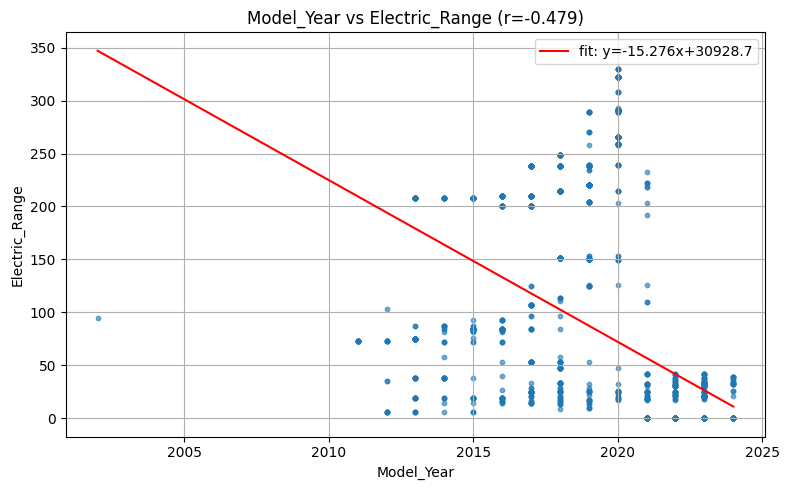

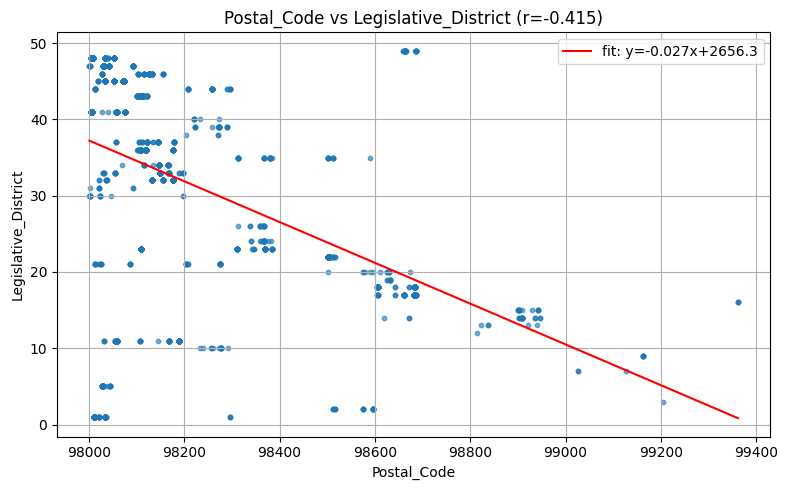

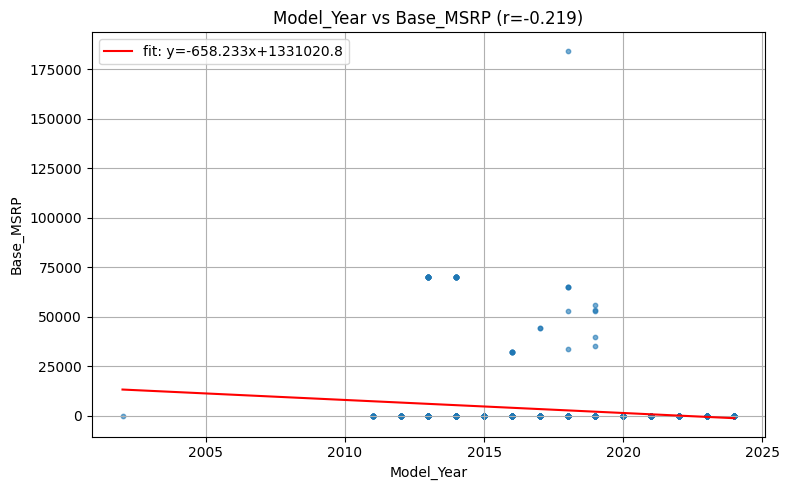

In [29]:
# Cell 4 — plot top 3 correlated pairs (scatter + simple linear fit)
import numpy as np

if len(numeric_cols) < 2:
    print("Not enough numeric columns for scatter plots.")
else:
    for absr, r, a, b in pairs_sorted[:3]:
        data = pdf[[a, b]].dropna()
        if data.shape[0] < 5:
            print(f"Skipping plot for {a} vs {b} — not enough non-null rows ({data.shape[0]}).")
            continue
        x = data[a].values
        y = data[b].values
        plt.figure()
        plt.scatter(x, y, s=10, alpha=0.6)
        # simple linear fit if >1 point
        if x.size > 1:
            m, c = np.polyfit(x, y, 1)
            xs = np.linspace(np.min(x), np.max(x), 100)
            plt.plot(xs, m*xs + c, color='red', linewidth=1.5, label=f'fit: y={m:.3f}x+{c:.1f}')
            plt.legend()
        plt.xlabel(a); plt.ylabel(b)
        plt.title(f"{a} vs {b} (r={r:.3f})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [31]:
# Cell 5.1 — define categorical and numeric columns for analysis
cat_cols = [c for c in ["Make", "Electric_Vehicle_Type", "City", "County", "State"] if c in pdf.columns]
num_targets = [c for c in ["Base_MSRP", "Electric_Range"] if c in pdf.columns]

print("Categorical columns available:", cat_cols)
print("Numeric columns available:", num_targets)


Categorical columns available: ['Make', 'Electric_Vehicle_Type', 'City', 'County', 'State']
Numeric columns available: ['Base_MSRP', 'Electric_Range']


Top 10 Makes by number of vehicles:
           count         mean
Make                         
TESLA        924  1512.987013
NISSAN       167     0.000000
CHEVROLET    139     0.000000
BMW           87  2267.816092
FORD          79     0.000000
JEEP          76     0.000000
KIA           74  2617.567568
HYUNDAI       66     0.000000
TOYOTA        61     0.000000
CHRYSLER      60   666.583333


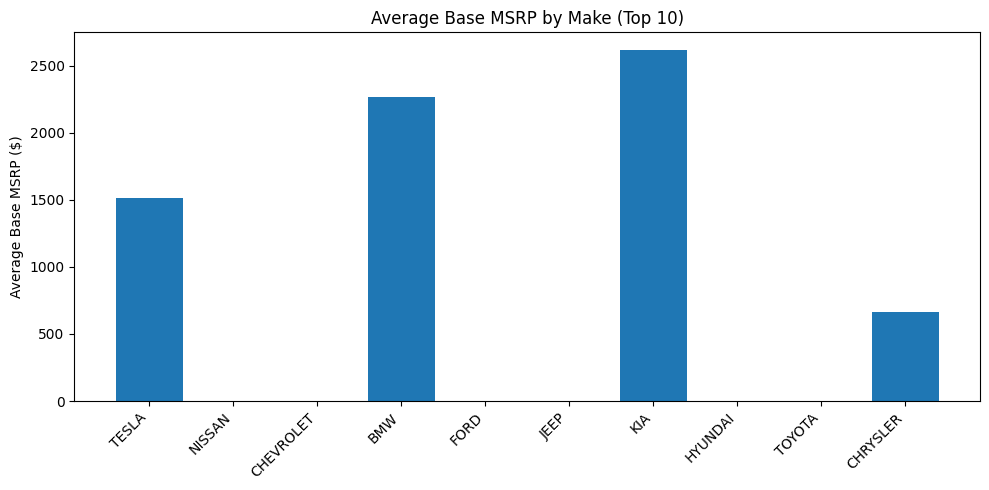

In [32]:
# Cell 5.2 — analyze Base_MSRP by Make
if "Make" in pdf.columns and "Base_MSRP" in pdf.columns:
    make_msrp = pdf.groupby("Make")["Base_MSRP"].agg(['count', 'mean']).sort_values('count', ascending=False).head(10)
    print("Top 10 Makes by number of vehicles:")
    print(make_msrp)

    plt.figure(figsize=(10,5))
    plt.bar(make_msrp.index, make_msrp["mean"])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Average Base MSRP ($)")
    plt.title("Average Base MSRP by Make (Top 10)")
    plt.tight_layout()
    plt.show()
else:
    print("Columns Make or Base_MSRP not available.")


Top 10 Makes by Electric Range:
           count       mean
Make                       
TESLA        924  90.649351
NISSAN       167  90.898204
CHEVROLET    139  88.482014
BMW           87  42.229885
FORD          79  11.860759
JEEP          76  22.000000
KIA           74  53.797297
HYUNDAI       66  15.924242
TOYOTA        61  26.147541
CHRYSLER      60  32.150000


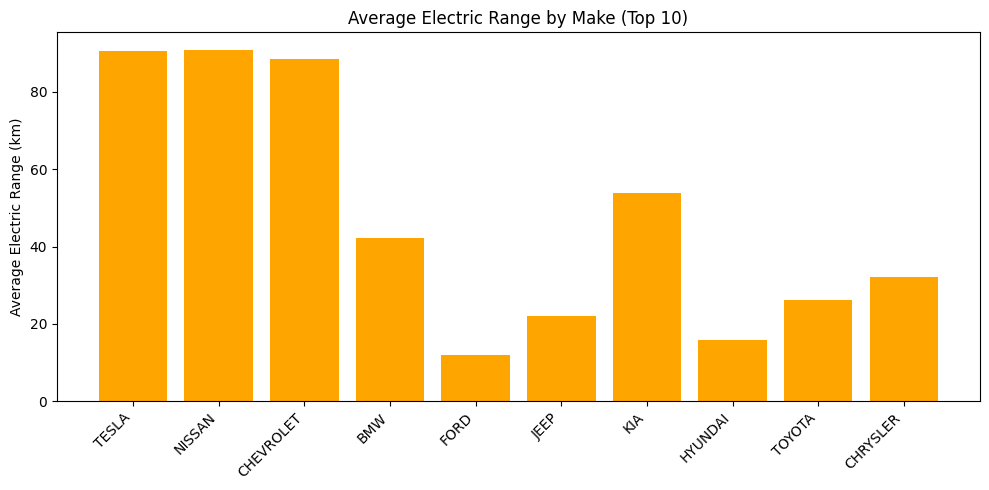

In [33]:
# Cell 5.3 — analyze Electric_Range by Make
if "Make" in pdf.columns and "Electric_Range" in pdf.columns:
    make_range = pdf.groupby("Make")["Electric_Range"].agg(['count', 'mean']).sort_values('count', ascending=False).head(10)
    print("Top 10 Makes by Electric Range:")
    print(make_range)

    plt.figure(figsize=(10,5))
    plt.bar(make_range.index, make_range["mean"], color='orange')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Average Electric Range (km)")
    plt.title("Average Electric Range by Make (Top 10)")
    plt.tight_layout()
    plt.show()
else:
    print("Columns Make or Electric_Range not available.")


Average Base MSRP by Electric Vehicle Type:
                                        count         mean
Electric_Vehicle_Type                                     
Battery Electric Vehicle (BEV)           1585  1004.227129
Plug-in Hybrid Electric Vehicle (PHEV)    453  1671.832230


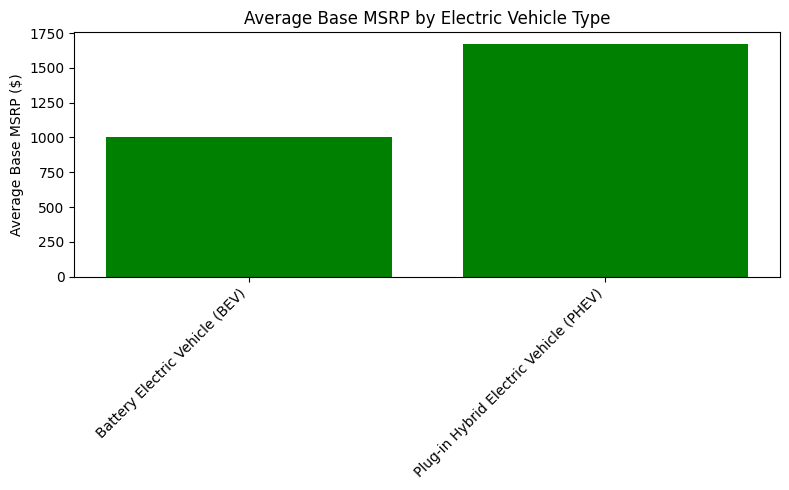

In [34]:
# Cell 5.4 — analyze Base_MSRP by Electric Vehicle Type
if "Electric_Vehicle_Type" in pdf.columns and "Base_MSRP" in pdf.columns:
    type_msrp = pdf.groupby("Electric_Vehicle_Type")["Base_MSRP"].agg(['count', 'mean']).sort_values('count', ascending=False)
    print("Average Base MSRP by Electric Vehicle Type:")
    print(type_msrp)

    plt.figure(figsize=(8,5))
    plt.bar(type_msrp.index, type_msrp["mean"], color='green')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Average Base MSRP ($)")
    plt.title("Average Base MSRP by Electric Vehicle Type")
    plt.tight_layout()
    plt.show()
else:
    print("Columns Electric_Vehicle_Type or Base_MSRP not available.")


Average Electric Range by Electric Vehicle Type:
                                        count       mean
Electric_Vehicle_Type                                   
Battery Electric Vehicle (BEV)           1585  77.307886
Plug-in Hybrid Electric Vehicle (PHEV)    453  29.260486


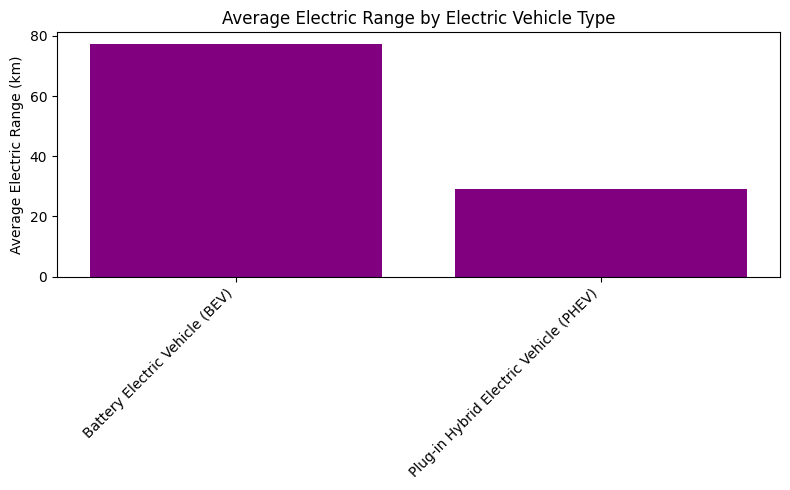

In [35]:
# Cell 5.5 — analyze Electric_Range by Electric Vehicle Type
if "Electric_Vehicle_Type" in pdf.columns and "Electric_Range" in pdf.columns:
    type_range = pdf.groupby("Electric_Vehicle_Type")["Electric_Range"].agg(['count', 'mean']).sort_values('count', ascending=False)
    print("Average Electric Range by Electric Vehicle Type:")
    print(type_range)

    plt.figure(figsize=(8,5))
    plt.bar(type_range.index, type_range["mean"], color='purple')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Average Electric Range (km)")
    plt.title("Average Electric Range by Electric Vehicle Type")
    plt.tight_layout()
    plt.show()
else:
    print("Columns Electric_Vehicle_Type or Electric_Range not available.")


Top 10 Cities by Average Electric Range:
City
Quilcene           330.0
Brier              259.0
White Salmon       248.5
Nine Mile Falls    242.5
Port Angeles       220.0
Evans              215.0
Stanwood           215.0
Ronald             208.0
Woodland           208.0
Cle Elum           200.0
Name: Electric_Range, dtype: float64


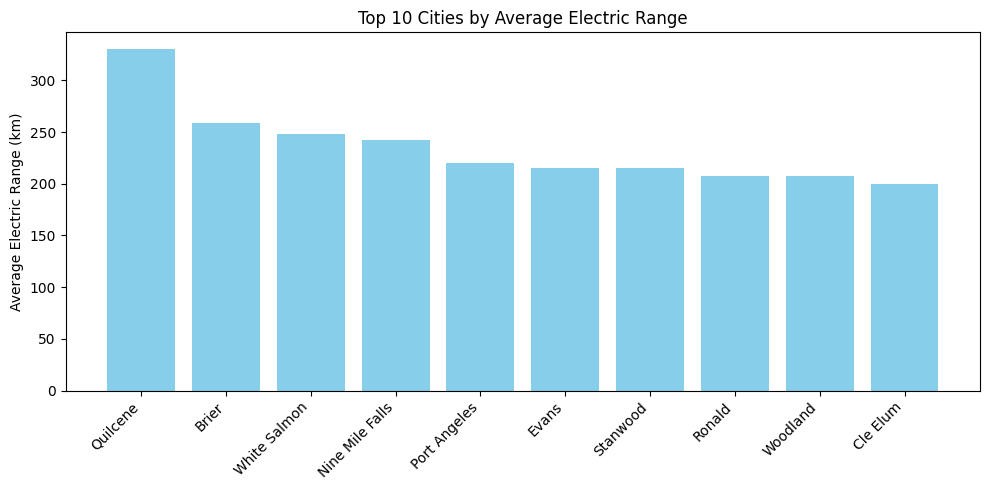

In [36]:
# Cell 5.6 — analyze Electric_Range by City
if "City" in pdf.columns and "Electric_Range" in pdf.columns:
    city_range = pdf.groupby("City")["Electric_Range"].mean().sort_values(ascending=False).head(10)
    print("Top 10 Cities by Average Electric Range:")
    print(city_range)

    plt.figure(figsize=(10,5))
    plt.bar(city_range.index, city_range.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Average Electric Range (km)")
    plt.title("Top 10 Cities by Average Electric Range")
    plt.tight_layout()
    plt.show()
else:
    print("Columns City or Electric_Range not available.")
